In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import seaborn as sns

from anomatools.models import SSkNNO, SSDO
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from sklearn.neighbors import NearestNeighbors,KernelDensity
from anomatools.models.scalers._scalers import *

import warnings
warnings.filterwarnings("ignore")


In [2]:
def get_labels(X_vals, knngroundtruth, reference_score):
    dist, _ = knngroundtruth.kneighbors(X_vals)
    distances = [dist[i][- 1] for i in range(len(dist))]
    y = -np.ones(len(X_vals), int)
    y[distances>=reference_score] = 1
    return y

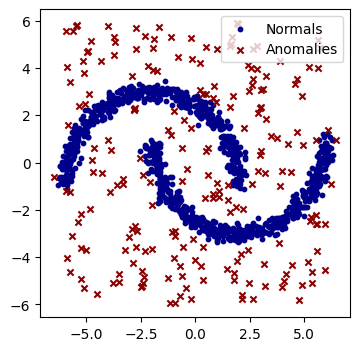

In [3]:
# Create the toy dataset
n_samples = 1000
n_outliers = 250
np.random.seed(331)

X = 4.0*(make_moons(n_samples=n_samples, noise=0.05, random_state=331)[0] - np.array([0.5, 0.25]))
X = np.concatenate([X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
y = np.concatenate((-np.ones(n_samples, int), np.ones(n_outliers,int)))
 
# Ground Truth -- Domain knowledge about labels:
np.random.seed(331)
X_clean = X[np.where(y==-1)[0]]
k_gt = 10
neigh = NearestNeighbors(n_neighbors=k_gt, n_jobs=-1)
# train for getting nearest neighbour
knngroundtruth = neigh.fit(X_clean)

dist, _ = knngroundtruth.kneighbors(X_clean)
distances = [dist[i][k_gt - 1] for i in range(len(dist))]
reference_score = np.percentile(distances, 99.)

y = get_labels(X, knngroundtruth, reference_score)

# X : Feature samples
# y : labels

plt.figure(figsize = (4,4))
plt.scatter(X[np.where(y==-1)[0],0],X[np.where(y==-1)[0],1], s = 10, marker = 'o', c = 'darkblue', label = 'Normals')
plt.scatter(X[np.where(y==1)[0],0],X[np.where(y==1)[0],1], s = 20, marker = 'x', c = 'darkred', label = 'Anomalies')
plt.legend()
plt.show()


In [4]:
#os.chdir('...') # Change to the directory where the EAP code is present
from opendataval.dataloader import DataFetcherTD
from opendataval.model import ClassifierUnweightedSkLearnWrapper
from opendataval.dataval import (AME, DVRL, BetaShapley, DataBanzhaf, DataOob, DataShapley, InfluenceSubsample, InfluenceFunction, KNNShapley, LavaEvaluator, LeaveOneOut, RandomEvaluator, RobustVolumeShapley, EAP)

In [5]:
from pyod.models.iforest import IForest

class IFor(IForest):
    def __init__(
        self, random_state=331):
        self.model = IForest(random_state=random_state)
        self.random_state = random_state
    def fit(self, X, sample_weight = None):
        self.model.fit(X)
        pass
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [6]:
fetcher = DataFetcherTD(X=X, y=y, datasets_path='datasets/', n_auxiliary_ds = 5, random_state = 1, device = 'cpu').setup(train_anom_prop = 0.02, fake_anom_prop = 0.48, test_anom_prop = 0.5)
pred_model = ClassifierUnweightedSkLearnWrapper(SSDO(k = 5, scaler=SquashScaler(contamination=fetcher.contamination), base_detector=IFor(random_state = 1)), positive_class = 1)
dataevaluator = EAP(random_state = 331)

dataval = dataevaluator.train(fetcher=fetcher, pred_model=pred_model, metric = 'f1', verbose = True)
data_values = dataval.evaluate_data_values()

print("ROC AUC for Q1:", roc_auc_score(y_true=np.concatenate((np.ones(len(data_values)//3), np.zeros(len(data_values) - len(data_values)//3))), y_score=data_values))

Splitting the Dataset into Training / Test / Fakes...


------------------------------------------------------------------------------------------------------
Summary of the dataset's characteristics
Initial shape: (1250, 2) with #anomalies: 210


Shapes after splitting are the following:
- Training: (840, 2) with # anomalies: 5
- Fakes: (300, 2) with # correct anomalies: 100 (33.3%) # polluted anomalies: 100 (33.3%) and # noise anomalies: 100 (33.3%)
- Test: (210, 2) with # anomalies: 105
------------------------------------------------------------------------------------------------------




100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

ROC AUC for Q1: 0.91265
